# Going Deeper #10
---
## 세그멘테이션 모델 만들기

In [ ]:
#필요한 라이브러리를 로드
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import PIL
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread
from skimage.transform import resize
from glob import glob
import albumentations


from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

print('check ✅')

2.8.0
1.21.5
7.1.2
0.18.3
0.1.12
check ✅


In [ ]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

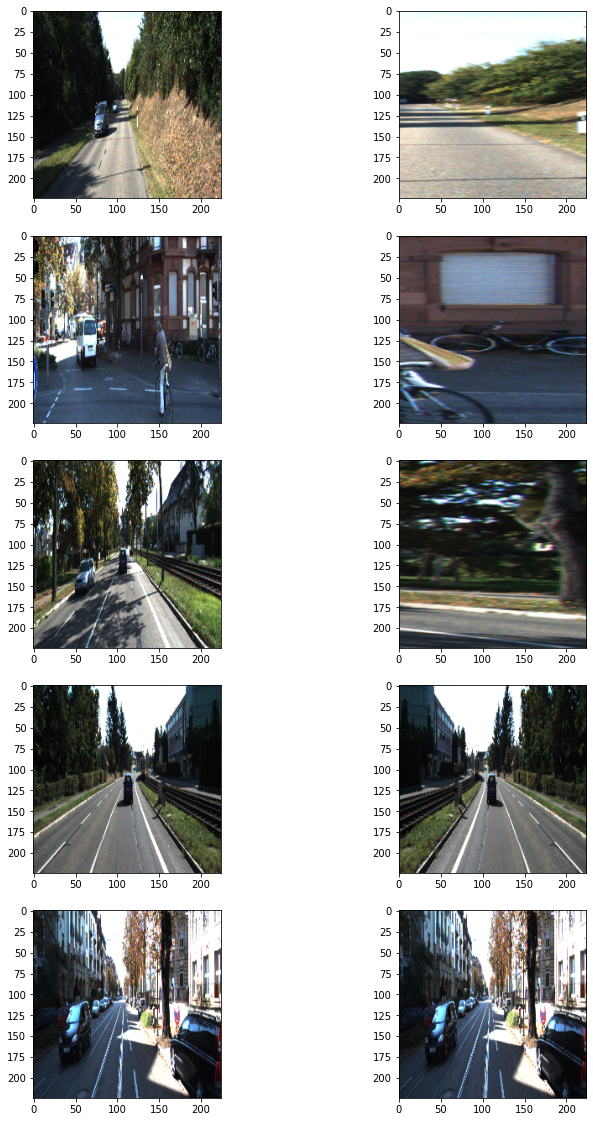

In [ ]:
dir_path = '/content/drive/MyDrive/ColabData/Aiffel/GoingDeeper/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [ ]:
class KittiGenerator(tf.keras.utils.Sequence):

  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):

    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수.
    # 이때 is_train에 따라 test set을 분리해서 load.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력 생성.
    # 입력은 resize및 augmentation이 적용된 input image
    # 출력은 semantic label
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# UNET

In [ ]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [ ]:
model_path = '/content/drive/MyDrive/ColabData/Aiffel/GoingDeeper/semantic_segmentation/data/training/seg_model_unet.h5' 

model_unet = build_model()
model_unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model_unet.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_unet.save(model_path)  #학습한 모델을 저장.

Epoch 1/100
11/11 [==============================] - 20s 691ms/step - loss: 0.6875 - val_loss: 0.6806
Epoch 2/100
11/11 [==============================] - 7s 661ms/step - loss: 0.6592 - val_loss: 0.5952
Epoch 3/100
11/11 [==============================] - 7s 664ms/step - loss: 0.1560 - val_loss: 0.0368
Epoch 4/100
11/11 [==============================] - 7s 657ms/step - loss: 0.0362 - val_loss: 0.0320
Epoch 5/100
11/11 [==============================] - 7s 658ms/step - loss: 0.0290 - val_loss: 0.0268
Epoch 6/100
11/11 [==============================] - 7s 656ms/step - loss: 0.0297 - val_loss: 0.0278
Epoch 7/100
11/11 [==============================] - 7s 650ms/step - loss: 0.0264 - val_loss: 0.0268
Epoch 8/100
11/11 [==============================] - 7s 645ms/step - loss: 0.0230 - val_loss: 0.0276
Epoch 9/100
11/11 [==============================] - 7s 640ms/step - loss: 0.0213 - val_loss: 0.0277
Epoch 10/100
11/11 [==============================] - 7s 637ms/step - loss: 0.0227 - val_l

In [ ]:
model_path ='/content/drive/MyDrive/ColabData/Aiffel/GoingDeeper/semantic_segmentation/data/training/seg_model_unet.h5' 
model_unet = tf.keras.models.load_model(model_path)

In [ ]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

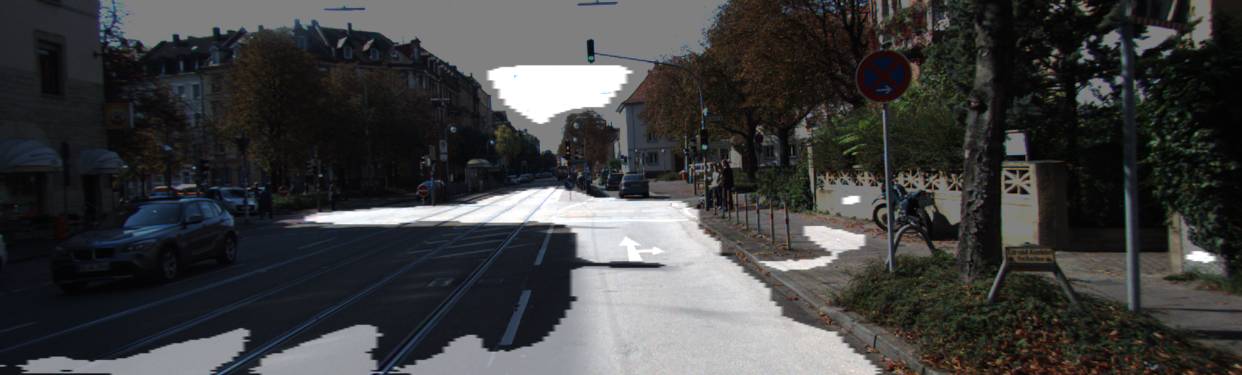

In [ ]:
i = 1   
get_output(
     model_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [ ]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.419641


0.41964089410040306

## UNET ++

In [ ]:
def UNetPlusPlus(img_rows, img_cols, color_type=1, num_class=1, deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    # Handle Dimension Ordering for different backends
    global bn_axis
    if K.image_dim_ordering() == 'tf':
      bn_axis = 3
      img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')
    else:
      bn_axis = 1
      img_input = Input(shape=(color_type, img_rows, img_cols), name='main_input')

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(input=img_input, output=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
    else:
        model = Model(input=img_input, output=[nestnet_output_4])

    return model


In [ ]:
# ljh415 님의 github  
def build_UNet_Plus(input_shape=(224, 224, 3), n = 32) :
    
    filters = [n, n*2, n*4, n*8, n*16]
    
    inputs = Input(input_shape)
    
    #conv0_0
    conv001 = Conv2D(filters=filters[0], kernel_size=3, padding='same', kernel_initializer='he_normal', name='conv0_0_1')(inputs)
    bn001 = BatchNormalization()(conv001)
    act001 = Activation('relu')(bn001)
    conv002 = Conv2D(filters=filters[0], kernel_size=3, padding='same', kernel_initializer='he_normal', name='conv0_0_2')(act001)
    bn002 = BatchNormalization()(conv002)
    conv00 = Activation('relu')(bn002)
    
    #conv1_0
    conv00_down = MaxPooling2D(strides=2)(conv00)
    conv101 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_1')(conv00_down)
    bn101 = BatchNormalization()(conv101)
    act101 = Activation('relu')(bn101)
    conv102 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_2')(act101)
    bn102 = BatchNormalization()(conv102)
    conv10 = Activation('relu')(bn102)
    
    #conv2_0
    conv10_down = MaxPooling2D(strides=2)(conv10)
    conv201 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_1')(conv10_down)
    bn201 = BatchNormalization()(conv201)
    act201 = Activation('relu')(bn201)
    conv202 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_2')(act201)
    bn202 = BatchNormalization()(conv202)
    conv20 = Activation('relu')(bn202)
    
    #conv3_0
    conv20_down = MaxPooling2D(strides=2)(conv20)
    conv301 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_1')(conv20_down)
    bn301 = BatchNormalization()(conv301)
    act301 = Activation('relu')(bn301)
    conv302 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_2')(act301)
    bn302 = BatchNormalization()(conv302)
    conv30 = Activation('relu')(bn302)
    
    #conv4_0
    conv30_down = MaxPooling2D(strides=2)(conv30)
    conv401 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_1')(conv30_down)
    bn401 = BatchNormalization()(conv401)
    act401 = Activation('relu')(bn401)
    conv402 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_2')(act401)
    bn402 = BatchNormalization()(conv402)
    conv40 = Activation('relu')(bn402)
    
    
    
    #conv0_1
    conv10_up = UpSampling2D()(conv10)
    conv01_in = Concatenate()([conv00, conv10_up])
    
    conv011 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_1')(conv01_in)
    bn011 = BatchNormalization()(conv011)
    act011 = Activation('relu')(bn011)
    conv012 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_2')(act011)
    bn012 = BatchNormalization()(conv012)
    conv01 = Activation('relu')(bn012)
    
    #conv1_1
    conv20_up = UpSampling2D()(conv20)
    conv11_in = Concatenate()([conv10, conv20_up])
    
    conv111 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_1')(conv11_in)
    bn111 = BatchNormalization()(conv111)
    act111 = Activation('relu')(bn111)
    conv112 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_2')(act111)
    bn112 = BatchNormalization()(conv112)
    conv11 = Activation('relu')(bn112)
    
    #conv2_1
    conv30_up = UpSampling2D()(conv30)
    conv21_in = Concatenate()([conv20, conv30_up])
    
    conv211 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_1')(conv21_in)
    bn211 = BatchNormalization()(conv211)
    act211 = Activation('relu')(bn211)
    conv212 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_2')(act211)
    bn212 = BatchNormalization()(conv212)
    conv21 = Activation('relu')(bn212)
    
    #conv3_1
    conv40_up = UpSampling2D()(conv40)
    conv31_in = Concatenate()([conv30, conv40_up])
    
    conv311 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_1')(conv31_in)
    bn311 = BatchNormalization()(conv311)
    act311 = Activation('relu')(bn311)
    conv312 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_2')(act311)
    bn312 = BatchNormalization()(conv312)
    conv31 = Activation('relu')(bn312)
    
    
    
    #conv0_2
    conv11_up = UpSampling2D()(conv11)
    conv02_in = Concatenate()([conv00, conv01, conv11_up])
    
    conv021 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_1')(conv02_in)
    bn021 = BatchNormalization()(conv021)
    act021 = Activation('relu')(bn021)
    conv022 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_2')(act021)
    bn022 = BatchNormalization()(conv022)
    conv02 = Activation('relu')(bn022)
    
    #conv1_2
    conv21_up = UpSampling2D()(conv21)
    conv12_in = Concatenate()([conv10, conv11, conv21_up])
    
    conv121 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_1')(conv12_in)
    bn121 = BatchNormalization()(conv121)
    act121 = Activation('relu')(bn121)
    conv122 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_2')(act121)
    bn122 = BatchNormalization()(conv122)
    conv12 = Activation('relu')(bn122)
    
    #conv2_2
    conv31_up = UpSampling2D()(conv31)
    conv22_in = Concatenate()([conv20, conv21, conv31_up])
    
    conv221 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_1')(conv22_in)
    bn221 = BatchNormalization()(conv221)
    act221 = Activation('relu')(bn221)
    conv222 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_2')(act221)
    bn222 = BatchNormalization()(conv222)
    conv22 = Activation('relu')(bn222)
    
    
    
    #conv0_3
    conv12_up = UpSampling2D()(conv12)
    conv03_in = Concatenate()([conv00, conv01, conv02, conv12_up])
    
    conv031 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_1')(conv03_in)
    bn031 = BatchNormalization()(conv031)
    act031 = Activation('relu')(bn031)
    conv032 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_2')(act031)
    bn032 = BatchNormalization()(conv032)
    conv03 = Activation('relu')(bn032)
    
    #conv1_3
    conv22_up = UpSampling2D()(conv22)
    conv13_in = Concatenate()([conv10, conv11, conv12, conv22_up])
    
    conv131 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_1')(conv13_in)
    bn131 = BatchNormalization()(conv131)
    act131 = Activation('relu')(bn131)
    conv132 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_2')(act131)
    bn132 = BatchNormalization()(conv132)
    conv13 = Activation('relu')(bn132)
    
    
    
    #conv0_4
    conv13_up = UpSampling2D()(conv13)
    conv04_in = Concatenate()([conv00, conv01, conv02, conv03, conv13_up])
    
    conv041 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_1')(conv04_in)
    bn041 = BatchNormalization()(conv041)
    act041 = Activation('relu')(bn041)
    conv042 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_2')(act041)
    bn042 = BatchNormalization()(conv042)
    conv04 = Activation('relu')(bn042)
    
    output = Conv2D(1, 1, activation='sigmoid', name='final')(conv04)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [ ]:
model_path = '/content/drive/MyDrive/ColabData/Aiffel/GoingDeeper/semantic_segmentation/seg_model_unet_pp_2.h5'

model_unet_pp = build_model()
model_unet_pp.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model_unet_pp.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_unet_pp.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 9s 659ms/step - loss: 0.6935 - val_loss: 0.6926
Epoch 2/100
11/11 [==============================] - 7s 631ms/step - loss: 0.6924 - val_loss: 0.6921
Epoch 3/100
11/11 [==============================] - 7s 638ms/step - loss: 0.6918 - val_loss: 0.6916
Epoch 4/100
11/11 [==============================] - 7s 644ms/step - loss: 0.6913 - val_loss: 0.6910
Epoch 5/100
11/11 [==============================] - 7s 650ms/step - loss: 0.6907 - val_loss: 0.6905
Epoch 6/100
11/11 [==============================] - 7s 644ms/step - loss: 0.6902 - val_loss: 0.6900
Epoch 7/100
11/11 [==============================] - 7s 638ms/step - loss: 0.6897 - val_loss: 0.6894
Epoch 8/100
11/11 [==============================] - 7s 636ms/step - loss: 0.6892 - val_loss: 0.6889
Epoch 9/100
11/11 [==============================] - 7s 631ms/step - loss: 0.6886 - val_loss: 0.6884
Epoch 10/100
11/11 [==============================] - 7s 630ms/step - loss: 0.6880 - val_lo

In [ ]:
model_path ='/content/drive/MyDrive/ColabData/Aiffel/GoingDeeper/semantic_segmentation/seg_model_unet_pp_1.h5' 
model_unet_pp = tf.keras.models.load_model(model_path)

In [ ]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

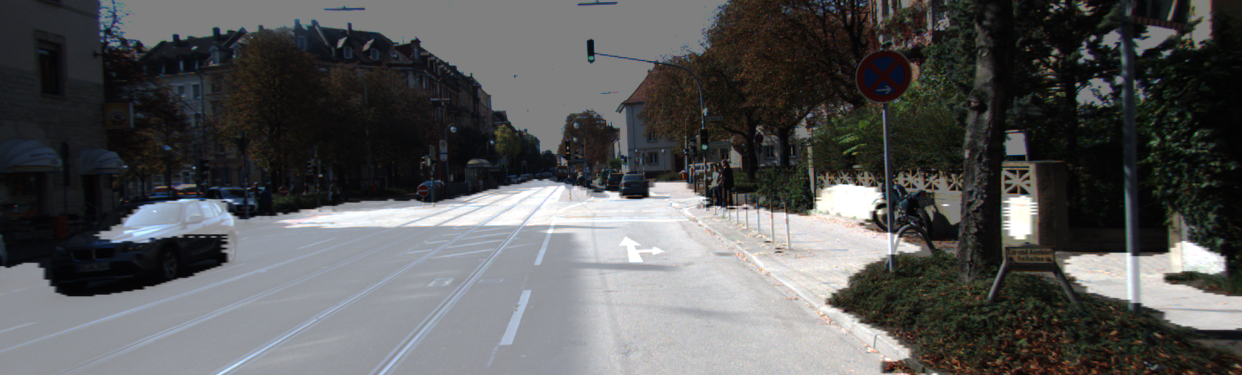

In [ ]:
i = 1   
get_output(
     model_unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [ ]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [ ]:
i = 1
output, prediction, target = get_output(
     model_unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.769226


0.7692260404499908

# 회고

## 모델에 대한 평가
---
- UNET을 활용했을 때에 비하여 IoU가 커진 것을 볼 수 있다.
- IOU, 0.4196 --> 0.7692
- UNET++ 직접 구현하기위해 여러 코드들을 찾아보았지만 쉽지 않아 앞서 수강했던 다른 분들의 코드들을 많이 참고하였다.


## 후기
---
개인적인 일정이 바빠 이번 노드는 특히나 많이 신경쓰지 못한 것 같다. 추후 보강할 수 있도록 해야겠다.

## Reference
- https://github.com/qsdcfd/AIFFEL/blob/TIL/Personal-Project/Going%20Deeper%20(CV)/Going%20Deeper%2005/GD10%5Dsemantic%20segmentation.Sehyun.ipynb
- https://github.com/ljh415/AIFFEL/blob/master/Going_Deeper/04.Semantic_Segmentation_UNet%2B%2B/Semantic_Segmentation.ipynb
- https://github.com/JaeHeee/AIFFEL_Project/blob/master/Going_Deeper/Segmentation.ipynb
- https://github.com/Woodywarhol9/aiffel/blob/main/CV/%5BG10%5DUnet_augmentation/%5BG10%5Dsegmentation_kitti.ipynb
- https://github.com/ljh415/AIFFEL/blob/master/Going_Deeper/04.Semantic_Segmentation_UNet%2B%2B/Semantic_Segmentation.ipynb
- 